<img src = "https://i.imgur.com/LKLpFOv.png">

In [1]:
import numpy as np 
import pandas as pd 
from tqdm import tqdm
import glob
import os
import matplotlib.pyplot as plt
import seaborn as sns
import pprint
import pydicom as dicom
import albumentations as A
import cv2

from colorama import Fore, Back, Style
# colored output
y_ = Fore.YELLOW
r_ = Fore.RED
g_ = Fore.GREEN
b_ = Fore.BLUE
m_ = Fore.MAGENTA

In [2]:
train_image_level = pd.read_csv("../input/siim-covid19-detection/train_image_level.csv")
train_study_level = pd.read_csv("../input/siim-covid19-detection/train_study_level.csv")

| id    | unique study identifier                                      |
|-------|--------------------------------------------------------------|
| boxes | bounding boxes in easily-readable dictionary format          |
| label | the correct prediction label for the provided bounding boxes |

In [3]:
train_image_level.head()

id                                              boxes  \
0  000a312787f2_image  [{'x': 789.28836, 'y': 582.43035, 'width': 102...   
1  000c3a3f293f_image                                                NaN   
2  0012ff7358bc_image  [{'x': 677.42216, 'y': 197.97662, 'width': 867...   
3  001398f4ff4f_image  [{'x': 2729, 'y': 2181.33331, 'width': 948.000...   
4  001bd15d1891_image  [{'x': 623.23328, 'y': 1050, 'width': 714, 'he...   

                                               label StudyInstanceUID  
0  opacity 1 789.28836 582.43035 1815.94498 2499....     5776db0cec75  
1                                     none 1 0 0 1 1     ff0879eb20ed  
2  opacity 1 677.42216 197.97662 1545.21983 1197....     9d514ce429a7  
3    opacity 1 2729 2181.33331 3677.00012 2785.33331     28dddc8559b2  
4  opacity 1 623.23328 1050 1337.23328 2156 opaci...     dfd9fdd85a3e

| id                       | unique study identifier                                  |
|--------------------------|----------------------------------------------------------|
| Negative for Pneumonia   | 1 : if the study is negative for pneumonia, 0: otherwise |
| Typical Appearance       | 1: if the study has this appearance, 0: otherwise        |
| Indeterminate Appearance | 1: if the study has this appearance, 0: otherwise        |
| Atypical Appearance      | 1: if the study has this appearance, 0: otherwise        |

In [4]:
train_study_level.head()

id  Negative for Pneumonia  Typical Appearance  \
0  00086460a852_study                       0                   1   
1  000c9c05fd14_study                       0                   0   
2  00292f8c37bd_study                       1                   0   
3  005057b3f880_study                       1                   0   
4  0051d9b12e72_study                       0                   0   

   Indeterminate Appearance  Atypical Appearance  
0                         0                    0  
1                         0                    1  
2                         0                    0  
3                         0                    0  
4                         0                    1

In [5]:
train_directory = "../input/siim-covid19-detection/train/"
test_directory = "../input/siim-covid19-detection/test/"

train_study_level['StudyInstanceUID'] = train_study_level['id'].apply(lambda x: x.replace('_study', ''))
del train_study_level['id']
train_df = train_image_level.merge(train_study_level, on='StudyInstanceUID')

In [6]:
train_df.head()

id                                              boxes  \
0  000a312787f2_image  [{'x': 789.28836, 'y': 582.43035, 'width': 102...   
1  000c3a3f293f_image                                                NaN   
2  0012ff7358bc_image  [{'x': 677.42216, 'y': 197.97662, 'width': 867...   
3  001398f4ff4f_image  [{'x': 2729, 'y': 2181.33331, 'width': 948.000...   
4  001bd15d1891_image  [{'x': 623.23328, 'y': 1050, 'width': 714, 'he...   

                                               label StudyInstanceUID  \
0  opacity 1 789.28836 582.43035 1815.94498 2499....     5776db0cec75   
1                                     none 1 0 0 1 1     ff0879eb20ed   
2  opacity 1 677.42216 197.97662 1545.21983 1197....     9d514ce429a7   
3    opacity 1 2729 2181.33331 3677.00012 2785.33331     28dddc8559b2   
4  opacity 1 623.23328 1050 1337.23328 2156 opaci...     dfd9fdd85a3e   

   Negative for Pneumonia  Typical Appearance  Indeterminate Appearance  \
0                       0                   1                         0   
1                       1                   0                         0   
2                       0                   1                         0   
3                       0                   0                         0   
4                       0                   1                         0   

   Atypical Appearance  
0                    0  
1                    0  
2                    0  
3                    1  
4                    0

In [7]:
training_paths = []

for sid in tqdm(train_df['StudyInstanceUID']):
    training_paths.append(glob.glob(os.path.join(train_directory, sid +"/*/*"))[0])

train_df['path'] = training_paths

100%|██████████| 6334/6334 [00:27<00:00, 234.29it/s]


In [8]:
train_df.head()

id                                              boxes  \
0  000a312787f2_image  [{'x': 789.28836, 'y': 582.43035, 'width': 102...   
1  000c3a3f293f_image                                                NaN   
2  0012ff7358bc_image  [{'x': 677.42216, 'y': 197.97662, 'width': 867...   
3  001398f4ff4f_image  [{'x': 2729, 'y': 2181.33331, 'width': 948.000...   
4  001bd15d1891_image  [{'x': 623.23328, 'y': 1050, 'width': 714, 'he...   

                                               label StudyInstanceUID  \
0  opacity 1 789.28836 582.43035 1815.94498 2499....     5776db0cec75   
1                                     none 1 0 0 1 1     ff0879eb20ed   
2  opacity 1 677.42216 197.97662 1545.21983 1197....     9d514ce429a7   
3    opacity 1 2729 2181.33331 3677.00012 2785.33331     28dddc8559b2   
4  opacity 1 623.23328 1050 1337.23328 2156 opaci...     dfd9fdd85a3e   

   Negative for Pneumonia  Typical Appearance  Indeterminate Appearance  \
0                       0                   1                         0   
1                       1                   0                         0   
2                       0                   1                         0   
3                       0                   0                         0   
4                       0                   1                         0   

   Atypical Appearance                                               path  
0                    0  ../input/siim-covid19-detection/train/5776db0c...  
1                    0  ../input/siim-covid19-detection/train/ff0879eb...  
2                    0  ../input/siim-covid19-detection/train/9d514ce4...  
3                    1  ../input/siim-covid19-detection/train/28dddc85...  
4                    0  ../input/siim-covid19-detection/train/dfd9fdd8...

# Distribution of labels

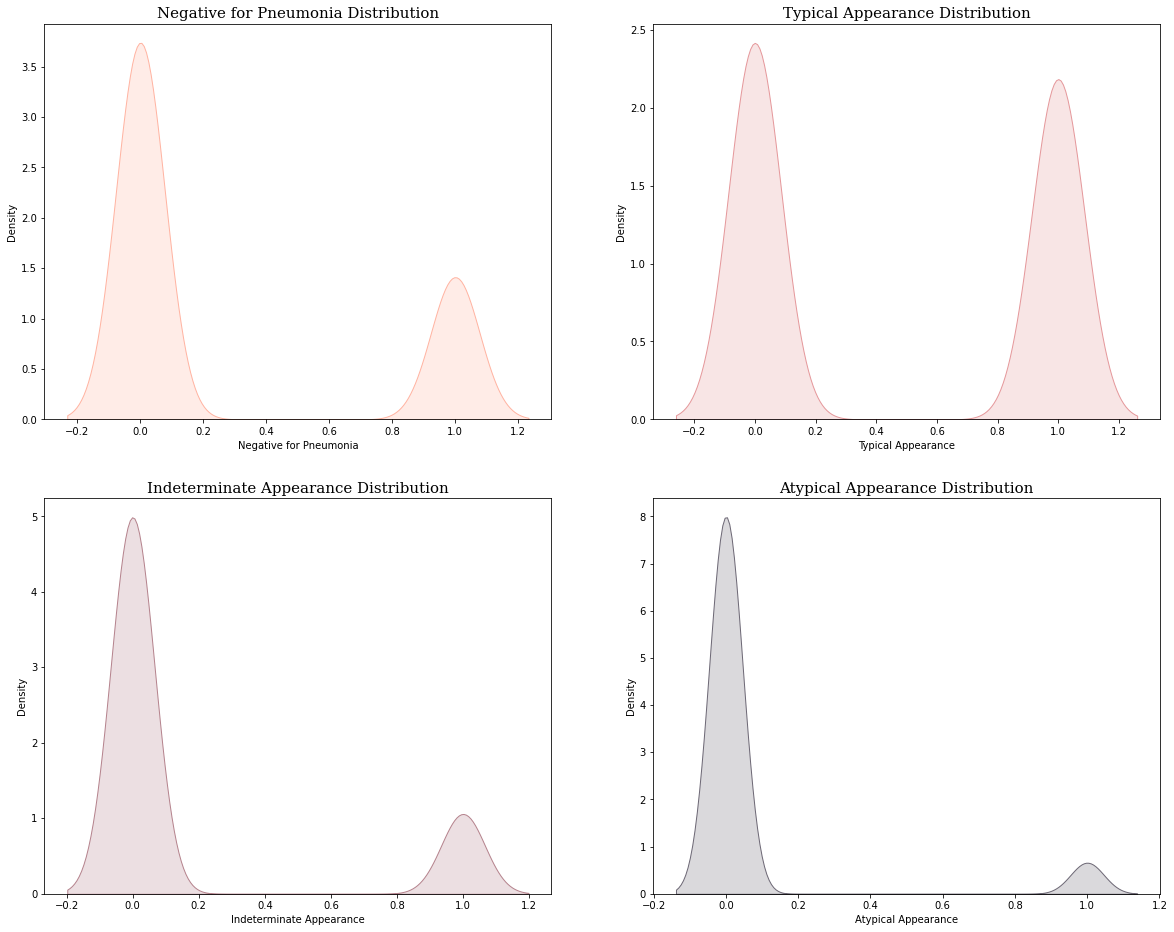

In [9]:
fig, ax = plt.subplots(2,2,figsize=(20,16))
sns.kdeplot(train_df["Negative for Pneumonia"], shade=True,ax=ax[0,0],color="#ffb4a2")
ax[0,0].set_title("Negative for Pneumonia Distribution",font="Serif", fontsize=15)
sns.kdeplot(train_df["Typical Appearance"], shade=True,ax=ax[0,1],color="#e5989b")
ax[0,1].set_title("Typical Appearance Distribution",font="Serif", fontsize=15)
sns.kdeplot(train_df["Indeterminate Appearance"], shade=True,ax=ax[1,0],color="#b5838d")
ax[1,0].set_title("Indeterminate Appearance Distribution",font="Serif", fontsize=15)
sns.kdeplot(train_df["Atypical Appearance"], shade=True,ax=ax[1,1],color="#6d6875")
ax[1,1].set_title("Atypical Appearance Distribution",font="Serif", fontsize=15)
plt.show()

# Dicom data

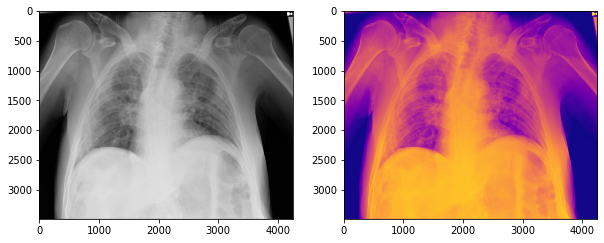

{'Accession Number': 'f6cd7f2019f5',
 'Bits Allocated': 16,
 'Bits Stored': 12,
 'Body Part Examined': 'CHEST',
 'Columns': 4256,
 'De-identification Method': 'CTP Default:  based on DICOM PS3.15 AnnexE. '
                             'Details in 0012,0064',
 'De-identification Method Code Sequence': '<Sequence, length 6>',
 'High Bit': 11,
 'Image Type': "['ORIGINAL', 'PRIMARY']",
 'Imager Pixel Spacing': '[0.1, 0.1]',
 'Instance Number': 1,
 'Modality': 'DX',
 'Patient ID': 'dcc3fdf6426a',
 "Patient's Name": "'d4268f26ed05'",
 "Patient's Sex": 'M',
 'Photometric Interpretation': 'MONOCHROME2',
 'Pixel Representation': 0,
 'Rows': 3488,
 'SOP Class UID': "'71228e4340de'",
 'SOP Instance UID': "'000a312787f2'",
 'Samples per Pixel': 1,
 'Series Instance UID': "'81456c9c5423'",
 'Series Number': 1,
 'Specific Character Set': 'ISO_IR 100',
 'Study Date': '526316e376d4',
 'Study ID': '55625fb42f3f',
 'Study Instance UID': "'5776db0cec75'",
 'Study Time': '8ccfb6acf07f'}


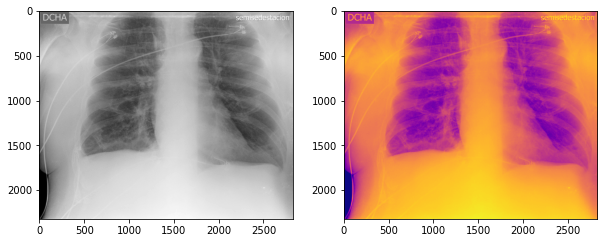

{'Accession Number': '1c2708371bc6',
 'Bits Allocated': 8,
 'Bits Stored': 8,
 'Body Part Examined': 'CHEST',
 'Columns': 2832,
 'De-identification Method': 'CTP Default:  based on DICOM PS3.15 AnnexE. '
                             'Details in 0012,0064',
 'De-identification Method Code Sequence': '<Sequence, length 6>',
 'High Bit': 7,
 'Image Type': "['ORIGINAL', 'PRIMARY']",
 'Imager Pixel Spacing': '[0.15, 0.15]',
 'Instance Number': 1,
 'Modality': 'CR',
 'Patient ID': 'f09ff9b7dab3',
 "Patient's Name": "'ef8c31f8dfdd'",
 "Patient's Sex": 'M',
 'Photometric Interpretation': 'MONOCHROME2',
 'Pixel Representation': 0,
 'Rows': 2320,
 'SOP Class UID': "'03a65300fa41'",
 'SOP Instance UID': "'000c3a3f293f'",
 'Samples per Pixel': 1,
 'Series Instance UID': "'d8a644cc4f93'",
 'Series Number': 1,
 'Specific Character Set': 'ISO_IR 100',
 'Study Date': 'd09eda152722',
 'Study ID': '55625fb42f3f',
 'Study Instance UID': "'ff0879eb20ed'",
 'Study Time': '543adb46f494'}


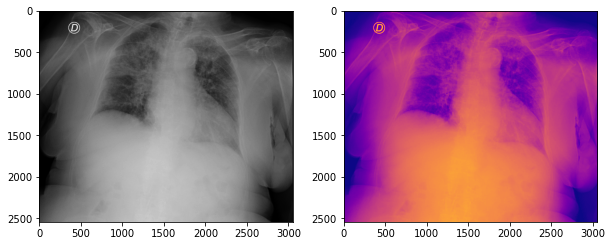

{'Accession Number': '99428f65d948',
 'Bits Allocated': 16,
 'Bits Stored': 12,
 'Body Part Examined': 'PORT CHEST',
 'Columns': 3056,
 'De-identification Method': 'CTP Default:  based on DICOM PS3.15 AnnexE. '
                             'Details in 0012,0064',
 'De-identification Method Code Sequence': '<Sequence, length 6>',
 'High Bit': 11,
 'Image Type': "['DERIVED', 'PRIMARY']",
 'Imager Pixel Spacing': '[0.139, 0.139]',
 'Instance Number': 1,
 'Modality': 'DX',
 'Patient ID': '6a02c0731039',
 "Patient's Name": "'2f2fb944fe44'",
 "Patient's Sex": 'F',
 'Photometric Interpretation': 'MONOCHROME2',
 'Pixel Representation': 0,
 'Rows': 2544,
 'SOP Class UID': "'71228e4340de'",
 'SOP Instance UID': "'0012ff7358bc'",
 'Samples per Pixel': 1,
 'Series Instance UID': "'22897cd1daa0'",
 'Series Number': 1,
 'Specific Character Set': 'ISO_IR 100',
 'Study Date': '96fc21dd2b1f',
 'Study ID': '55625fb42f3f',
 'Study Instance UID': "'9d514ce429a7'",
 'Study Time': '746186a2bbf2'}


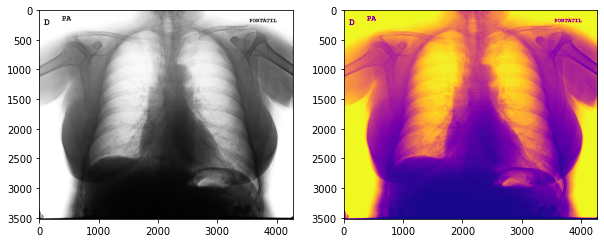

{'Accession Number': '7b889627faf1',
 'Bits Allocated': 16,
 'Bits Stored': 12,
 'Body Part Examined': 'CHEST',
 'Columns': 4280,
 'De-identification Method': 'CTP Default:  based on DICOM PS3.15 AnnexE. '
                             'Details in 0012,0064',
 'De-identification Method Code Sequence': '<Sequence, length 6>',
 'High Bit': 11,
 'Image Type': "['DERIVED', 'PRIMARY', 'POST_PROCESSED', 'RT', '', '', '', '', "
               "'100000']",
 'Imager Pixel Spacing': '[0.1, 0.1]',
 'Instance Number': 1002,
 'Modality': 'CR',
 'Patient ID': 'db63d9b7f61c',
 "Patient's Name": "'9ccd87b4511b'",
 "Patient's Sex": 'F',
 'Photometric Interpretation': 'MONOCHROME1',
 'Pixel Representation': 0,
 'Private Creator': 'GEIIS',
 'Rows': 3520,
 'SOP Class UID': "'03a65300fa41'",
 'SOP Instance UID': "'001398f4ff4f'",
 'Samples per Pixel': 1,
 'Series Instance UID': "'4d47bc042ee6'",
 'Series Number': 1002,
 'Specific Character Set': 'ISO_IR 100',
 'Study Date': '3f094e1700ec',
 'Study ID': '556

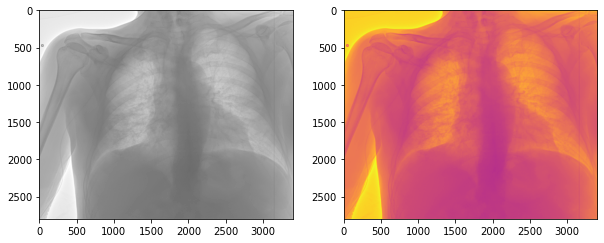

{'Accession Number': 'e9d93edf50c6',
 'Bits Allocated': 16,
 'Bits Stored': 15,
 'Body Part Examined': 'CHEST',
 'Columns': 3408,
 'De-identification Method': 'CTP Default:  based on DICOM PS3.15 AnnexE. '
                             'Details in 0012,0064',
 'De-identification Method Code Sequence': '<Sequence, length 6>',
 'High Bit': 14,
 'Image Type': "['ORIGINAL', 'PRIMARY']",
 'Imager Pixel Spacing': '[0.125, 0.125]',
 'Instance Number': 1,
 'Modality': 'DX',
 'Patient ID': '605693f36f43',
 "Patient's Name": "'35bf9ddbf9e9'",
 "Patient's Sex": 'M',
 'Photometric Interpretation': 'MONOCHROME1',
 'Pixel Representation': 0,
 'Rows': 2800,
 'SOP Class UID': "'71228e4340de'",
 'SOP Instance UID': "'001bd15d1891'",
 'Samples per Pixel': 1,
 'Series Instance UID': "'49170afa4f27'",
 'Series Number': 1,
 'Specific Character Set': 'ISO_IR 100',
 'Study Date': 'a69d89c8a474',
 'Study ID': '55625fb42f3f',
 'Study Instance UID': "'dfd9fdd85a3e'",
 'Study Time': '5399ff949226'}


In [10]:
def dicom_dataset_to_dict(filename):
    """Credit: https://github.com/pydicom/pydicom/issues/319"""
    
    dicom_header = dicom.dcmread(filename) 
    dicom_dict = {}
    repr(dicom_header)
    for dicom_value in dicom_header.values():
        if dicom_value.tag == (0x7fe0, 0x0010):
            # discard pixel data
            continue
        if type(dicom_value.value) == dicom.dataset.Dataset:
            dicom_dict[dicom_value.name] = dicom_dataset_to_dict(dicom_value.value)
        else:
            v = _convert_value(dicom_value.value)
            dicom_dict[dicom_value.name] = v
    fig, ax = plt.subplots(1, 2, figsize=[10, 8])
    ax[0].imshow(dicom_header.pixel_array, cmap=plt.cm.gray)
    ax[1].imshow(dicom_header.pixel_array, cmap=plt.cm.plasma)
    plt.show()
    
    return dicom_dict


def _sanitise_unicode(s):
    return s.replace(u"\u0000", "").strip()

def _convert_value(v):
    t = type(v)
    if t in (list, int, float):
        cv = v
    elif t == str:
        cv = _sanitise_unicode(v)
    elif t == bytes:
        s = v.decode('ascii', 'replace')
        cv = _sanitise_unicode(s)
    elif t == dicom.valuerep.DSfloat:
        cv = float(v)
    elif t == dicom.valuerep.IS:
        cv = int(v)
    else:
        cv = repr(v)
    return cv

for filename in train_df.path[0:5]:
    df = dicom_dataset_to_dict(filename)
    pprint.pprint(df)

Super thankful to @[xhlulu](https://www.kaggle.com/xhlulu) for converting [dicom image data to jpg files](https://www.kaggle.com/xhlulu/siim-covid-19-convert-to-jpg-256px)! ⚡

In [11]:
train_jpg_directory = '../input/siim-covid19-resized-to-256px-jpg/train'
test_jpg_directory = '../input/siim-covid19-resized-to-256px-jpg/test'

def getImagePaths(path):
    image_names = []
    for dirname, _, filenames in os.walk(path):
        for filename in filenames:
            fullpath = os.path.join(dirname, filename)
            image_names.append(fullpath)
    return image_names

train_images_path = getImagePaths(train_jpg_directory)
test_images_path = getImagePaths(test_jpg_directory)

print(f"{y_}Number of train images: {g_} {len(train_images_path)}\n")
print(f"{y_}Number of test images: {g_} {len(test_images_path)}\n")

def getShape(data, images_paths):
    shape = cv2.imread(images_paths[0]).shape
    for image_path in images_paths:
        image_shape=cv2.imread(image_path).shape
        if (image_shape!=shape):
            return data +" - Different image shape"
        else:
            return data +" - Same image shape " + str(shape)

Number of train images:  6334

Number of test images:  1263



### Checking if images in each directory have the same shape

In [12]:
getShape('train',train_images_path)

'train - Same image shape (256, 256, 3)'

In [13]:
getShape('test',test_images_path)

'test - Same image shape (256, 256, 3)'

# Data Augmentation

In [14]:
def plot_augmentations(images, titles, sup_title):
    fig, axes = plt.subplots(figsize=(20, 16), nrows=3, ncols=4, squeeze=False)
    
    for indx, (img, title) in enumerate(zip(images, titles)):
        axes[indx // 4][indx % 4].imshow(img)
        axes[indx // 4][indx % 4].set_title(title, fontsize=15)
        
    plt.tight_layout()
    fig.suptitle(sup_title, fontsize = 20)
    fig.subplots_adjust(wspace=0.2, hspace=0.2, top=0.93)
    plt.show()
    
def augment(paths, data):
    
    # list of albumentations
    albumentations = [A.RandomSunFlare(p=1), A.RandomFog(p=1), A.RandomBrightness(p=1),
                              A.RandomCrop(p=1,height = 128, width = 128), A.Rotate(p=1, limit=90),
                              A.RGBShift(p=1), A.RandomSnow(p=1),
                              A.HorizontalFlip(p=1), A.VerticalFlip(p=1), A.RandomContrast(limit = 0.5,p = 1),
                              A.HueSaturationValue(p=1,hue_shift_limit=20, sat_shift_limit=30, val_shift_limit=50)]
    
    # image titles
    titles = ["RandomSunFlare","RandomFog","RandomBrightness",
                       "RandomCrop","Rotate", "RGBShift", "RandomSnow","HorizontalFlip", "VerticalFlip", "RandomContrast","HSV"]
    
    for i in paths:
        image_path = i
        
        # getting image name from path
        image_name = image_path.split("/")[4].split(".")[0]
        
        # reading image
        image = cv2.imread(image_path)

        # list of images
        images = []
        
        # creating image augmentations
        for augmentation_type in albumentations:
            augmented_img = augmentation_type(image = image)['image']
            images.append(augmented_img)

        # original image
        titles.insert(0, "Original")
        images.insert(0,image)  
        
        sup_title = "Image Augmentation for " + data + " - " + image_name
        plot_augmentations(images, titles, sup_title)

### Data Augmentation (train samples)

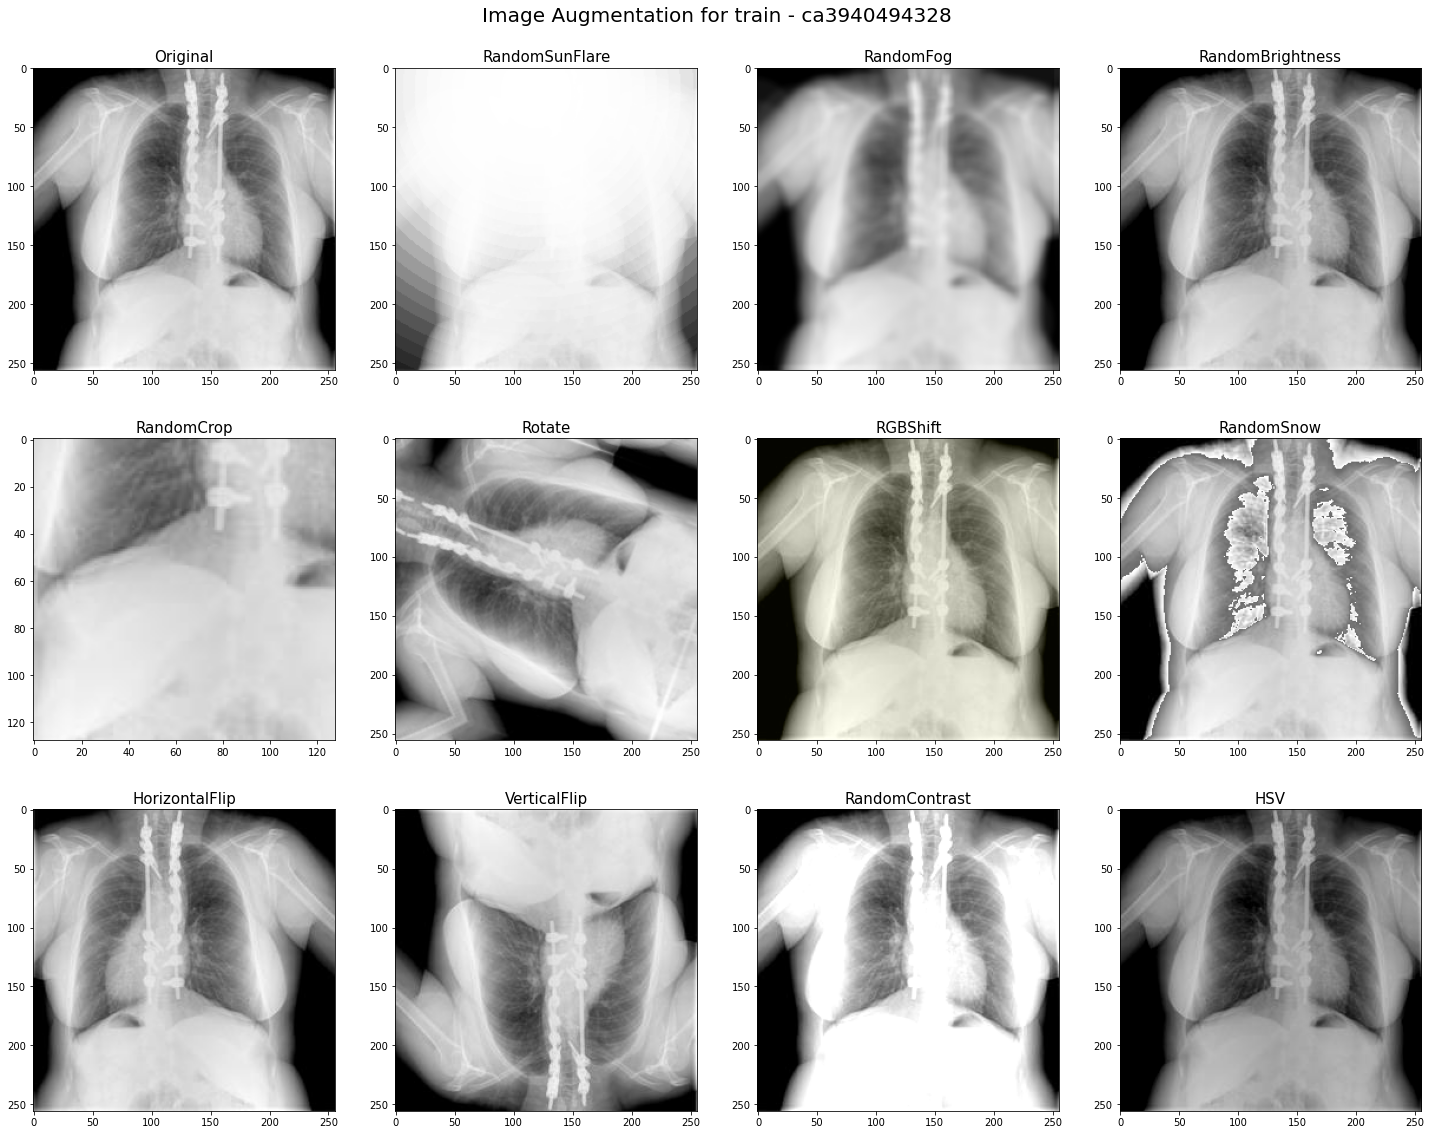

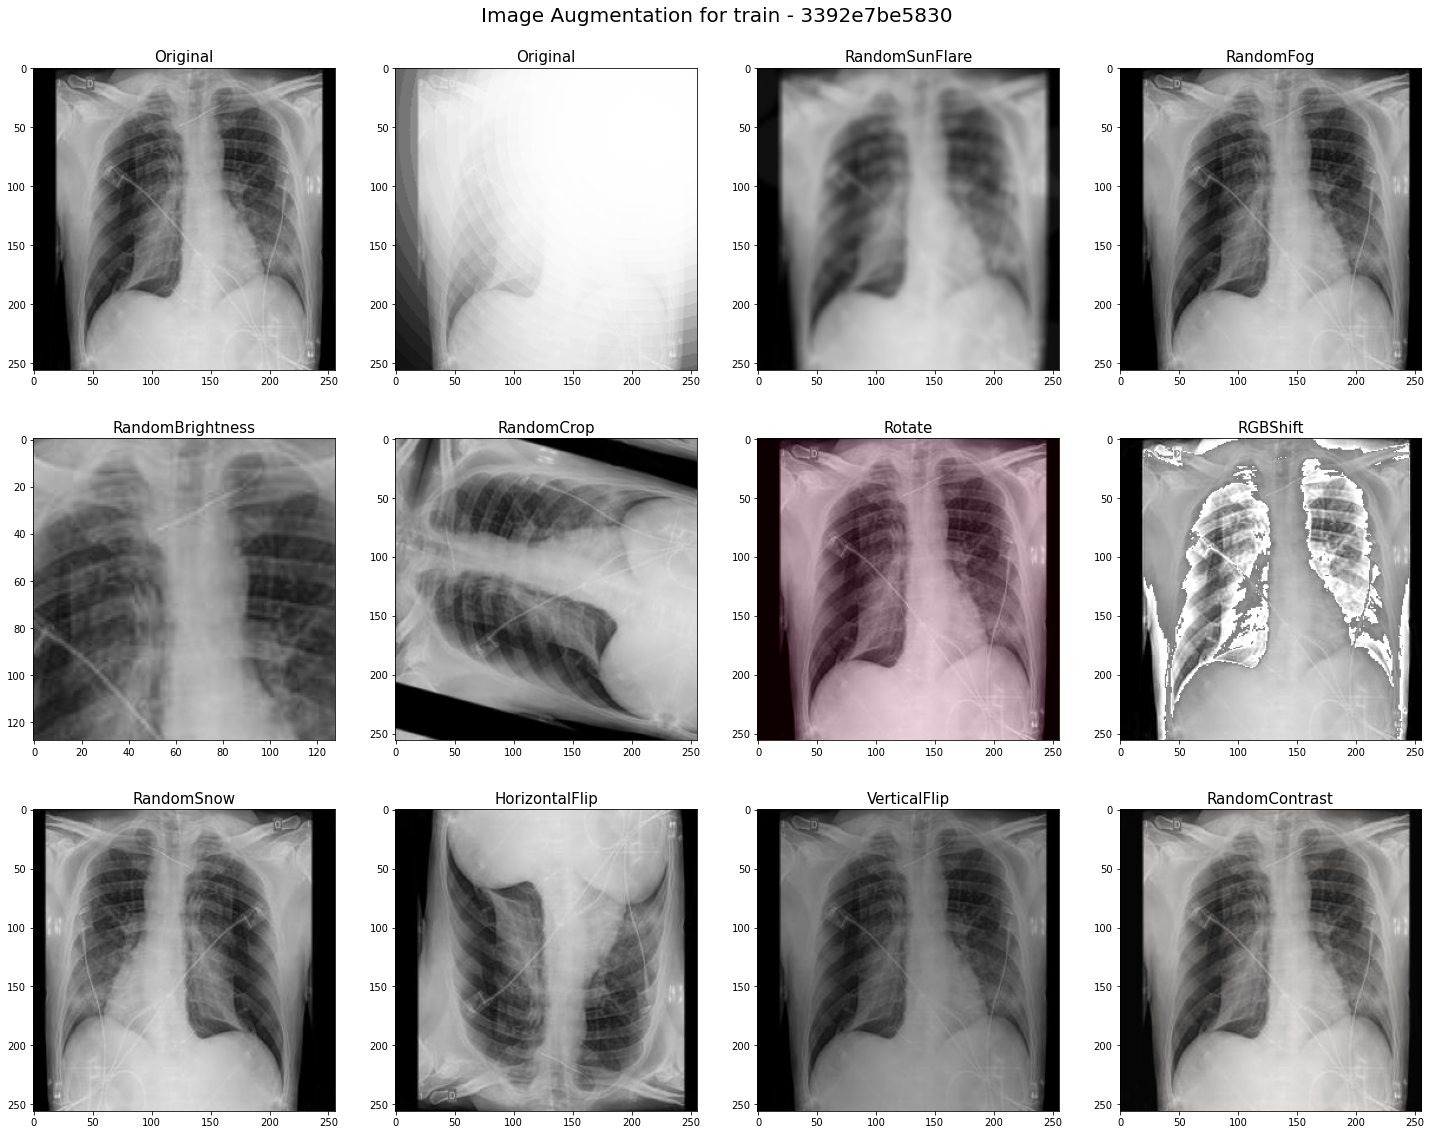

In [15]:
augment(train_images_path[0:2],'train')

### Data Augmentation (test samples)

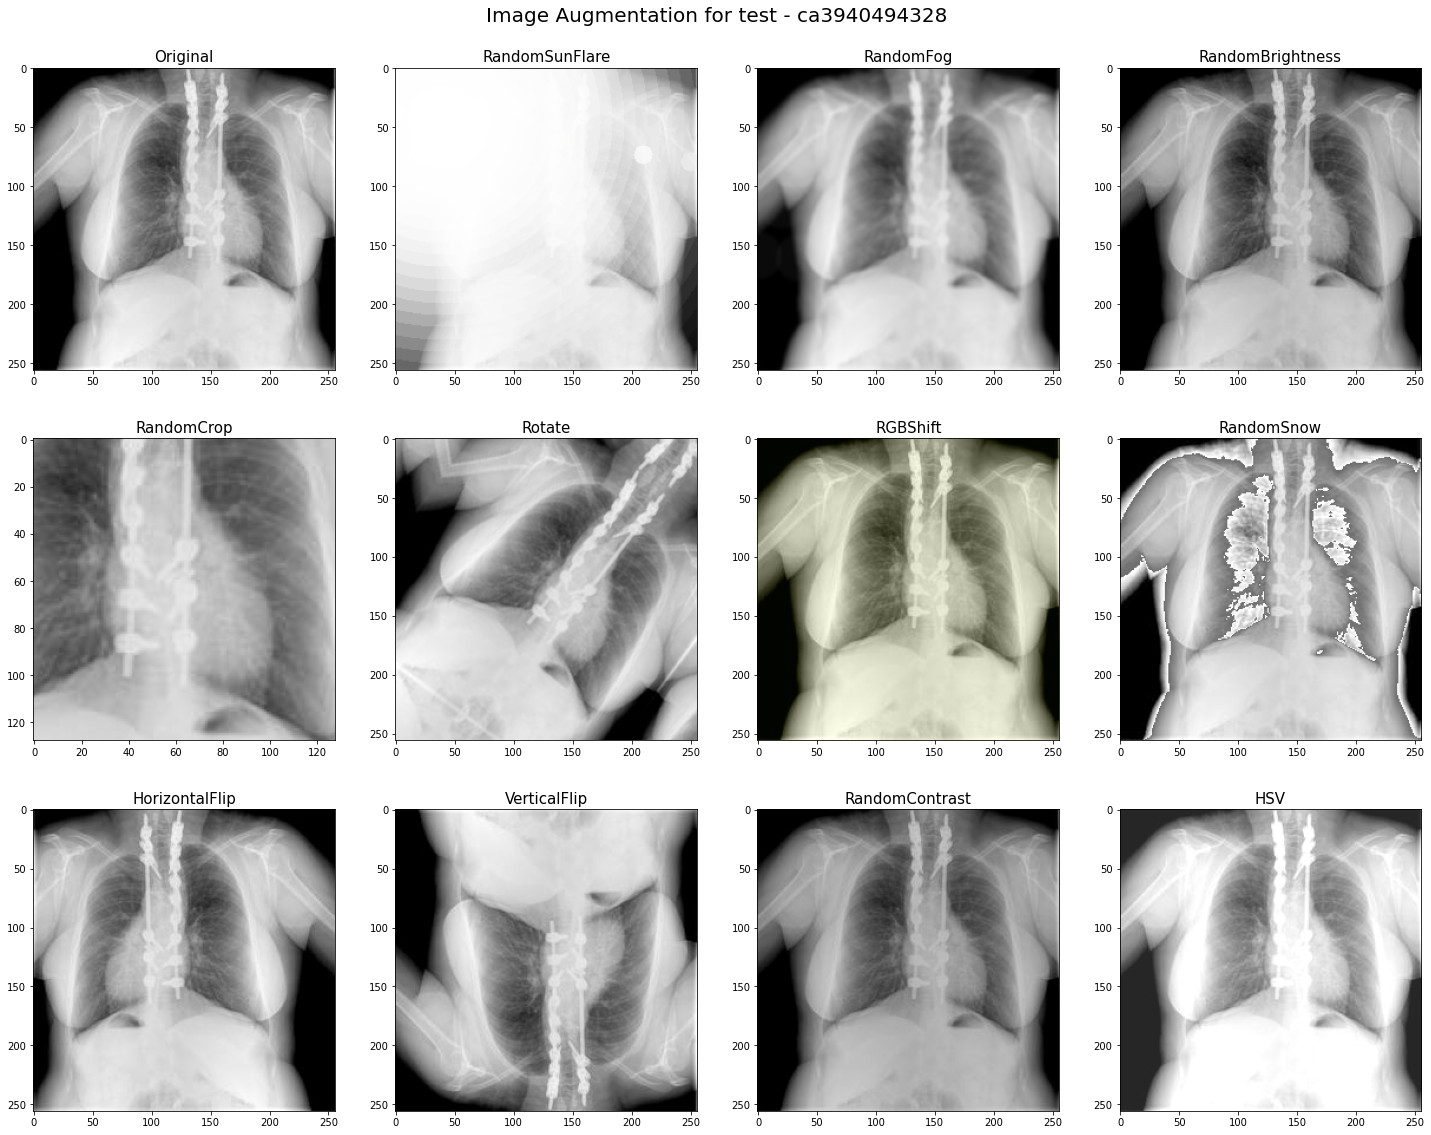

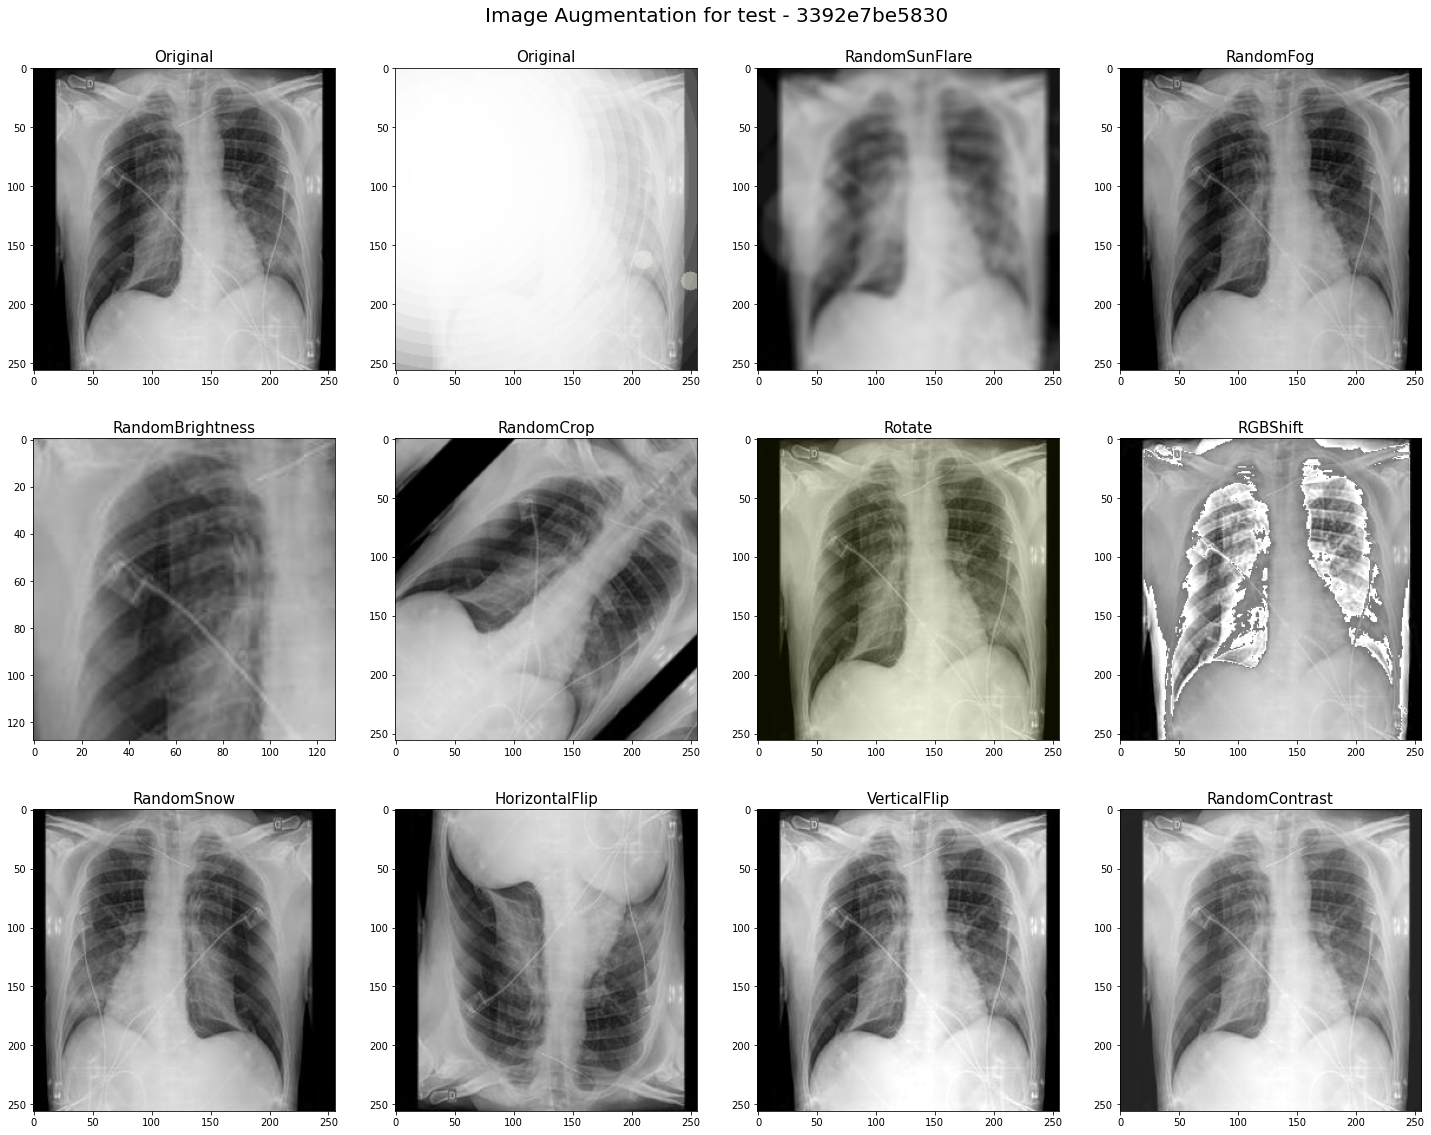

In [16]:
augment(train_images_path[0:2],'test')

I've created a [dataset](https://www.kaggle.com/ruchi798/siimfisabiorsna-covid19-detection-augmented) of image augmentations for all the training and testing images as well 🥳

Work in Progress ⏳